In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1

from phase_2.scripts.strategies.meta.meta_allocator_v1 import (
    build_regime_features,
    build_meta_raw_returns_param_v1,
)

from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)


In [11]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())


In [12]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(eq):
    eq = np.asarray(eq, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return np.nanmin(dd)


In [13]:
BASE_PARAMS = {
    "trend_mom60_min": 0.0,
    "trend_mom20_min": -0.01,
    "meanrev_mom20_max": -0.02,
    "meanrev_dd60_max": -0.03,
    "meanrev_vol20_max": 0.40,
}


In [14]:
variants = []

# small perturbations around baseline
for d_trend20 in [-0.005, 0.0, 0.005]:
    for d_mr20 in [-0.005, 0.0, 0.005]:
        p = BASE_PARAMS.copy()
        p["trend_mom20_min"] = BASE_PARAMS["trend_mom20_min"] + d_trend20
        p["meanrev_mom20_max"] = BASE_PARAMS["meanrev_mom20_max"] + d_mr20
        variants.append(p)

len(variants)


9

In [15]:
def run_portfolio_walkforward_for_params(params: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      portfolio_daily (date, portfolio_ret, portfolio_lev, year)
      state_yearly (year, pct_trend, pct_meanrev, pct_cash)
    """
    portfolio_daily_all = []
    state_rows = []

    for test_year in years:
        asset_daily = {}

        for sym, df in data.items():
            train = df[df["year"] < test_year].copy()
            test  = df[df["year"] == test_year].copy()

            if len(train) < 500 or len(test) < 60:
                continue

            trend_out = run_trend_strategy_v1(test, train_df=train)
            meanrev_out = run_meanrev_strategy_v1(test)

            regime = build_regime_features(test)
            meta = build_meta_raw_returns_param_v1(trend_out, meanrev_out, regime, params)

            meta["asset"] = sym
            meta["year"] = test_year
            asset_daily[sym] = meta

        if len(asset_daily) != len(ASSETS):
            continue

        # state mix (aggregate across assets for the year)
        states = pd.concat(asset_daily.values(), ignore_index=True)["state"]
        frac = states.value_counts(normalize=True).to_dict()

        state_rows.append({
            "year": test_year,
            "pct_trend": frac.get("TREND", 0.0),
            "pct_meanrev": frac.get("MEANREV", 0.0),
            "pct_cash": frac.get("CASH", 0.0),
        })

        # portfolio construction (meta_raw_ret)
        ret_wide = align_asset_returns(asset_daily)
        w = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
        port_raw = build_portfolio_raw_returns(ret_wide, w)

        # portfolio-level vol targeting
        vt = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)

        port = pd.DataFrame({
            "date": port_raw.index,
            "portfolio_raw_ret": port_raw.values,
            "portfolio_lev": vt["lev"].values,
            "portfolio_ret": vt["meta_ret"].values,
            "year": test_year,
        })

        portfolio_daily_all.append(port)

    portfolio_daily = pd.concat(portfolio_daily_all).sort_values("date").reset_index(drop=True)
    state_yearly = pd.DataFrame(state_rows).sort_values("year").reset_index(drop=True)

    return portfolio_daily, state_yearly


In [16]:
summary_rows = []
equity_curves = {}  # store for plotting a few later
state_maps = {}

for i, p in enumerate(variants):
    port_daily, state_yearly = run_portfolio_walkforward_for_params(p)

    eq = (1 + port_daily["portfolio_ret"]).cumprod()
    equity_curves[i] = (port_daily["date"], eq)
    state_maps[i] = state_yearly

    summary_rows.append({
        "variant_id": i,
        "trend_mom20_min": p["trend_mom20_min"],
        "meanrev_mom20_max": p["meanrev_mom20_max"],
        "sharpe": sharpe_ratio(port_daily["portfolio_ret"].values),
        "max_drawdown": max_drawdown(eq.values),
        "total_return": eq.iloc[-1] - 1.0,
        "avg_lev": port_daily["portfolio_lev"].mean(),
    })

sweep_summary = pd.DataFrame(summary_rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
sweep_summary


,variant_id,trend_mom20_min,meanrev_mom20_max,sharpe,max_drawdown,total_return,avg_lev
0,6,-0.005,-0.025,1.993205,-0.086890,6.463174,0.859077
1,7,-0.005,-0.020,1.976269,-0.084962,6.449386,0.856819
2,8,-0.005,-0.015,1.956364,-0.086309,6.345528,0.854474
3,3,-0.010,-0.025,1.811882,-0.082749,5.397965,0.854545
4,4,-0.010,-0.020,1.799207,-0.083886,5.394628,0.851704
5,5,-0.010,-0.015,1.786549,-0.085129,5.344179,0.849402
6,0,-0.015,-0.025,1.725598,-0.089178,4.951920,0.851632
7,1,-0.015,-0.020,1.712961,-0.094716,4.944769,0.848693
8,2,-0.015,-0.015,1.700589,-0.095701,4.894069,0.846203


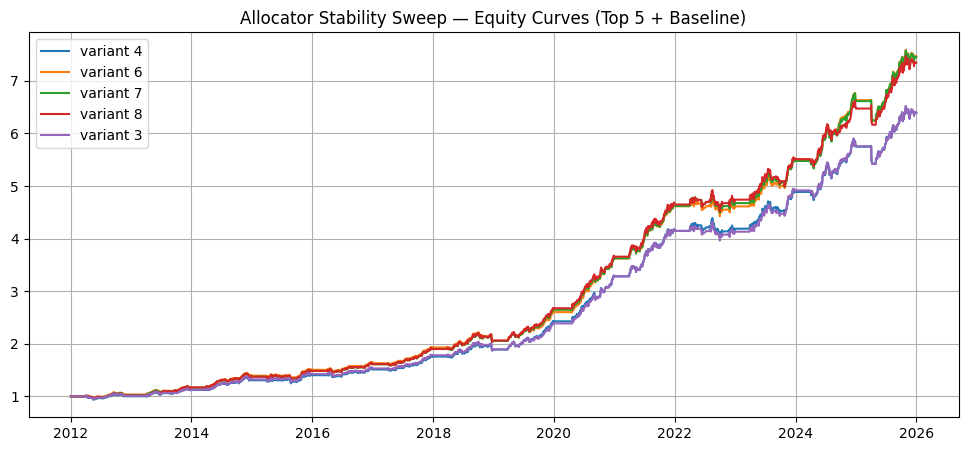

In [17]:
# find baseline variant (where both deltas are 0.0)
baseline_id = None
for i, p in enumerate(variants):
    if (p["trend_mom20_min"] == BASE_PARAMS["trend_mom20_min"]) and (p["meanrev_mom20_max"] == BASE_PARAMS["meanrev_mom20_max"]):
        baseline_id = i
        break

top_ids = sweep_summary["variant_id"].head(5).tolist()
plot_ids = [baseline_id] + [i for i in top_ids if i != baseline_id]

plt.figure(figsize=(12,5))
for vid in plot_ids:
    dts, eq = equity_curves[vid]
    plt.plot(dts, eq, label=f"variant {vid}")

plt.title("Allocator Stability Sweep — Equity Curves (Top 5 + Baseline)")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
compare_id = plot_ids[1]  # first non-baseline curve

base_states = state_maps[baseline_id].set_index("year")
comp_states = state_maps[compare_id].set_index("year")

delta = (comp_states - base_states).reset_index()
delta


,year,pct_trend,pct_meanrev,pct_cash
0,2012,-0.024000,-0.024000,0.048000
1,2013,-0.015873,-0.022487,0.038360
2,2014,-0.021164,-0.017196,0.038360
3,2015,-0.021164,-0.022487,0.043651
4,2016,-0.025132,-0.009259,0.034392
5,2017,-0.019920,-0.006640,0.026560
6,2018,-0.011952,-0.014608,0.026560
7,2019,-0.013228,-0.014550,0.027778
8,2020,-0.015810,-0.007905,0.023715
9,2021,-0.019841,-0.010582,0.030423
